In [1]:
## Common import cell!

%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.cluster
import sklearn.svm
import sqlite3

font = {'size'   : 18}

plt.matplotlib.rc('font', **font)

# Machine Learning: Classification

# 1. Data preparation

From preliminary data analysis, I have identified several factors which may be correlated with wildfire risk, and therefore, may be useful in characterizing the cause of a given wildfire. These features are: discovery day, fire year, fire size, latitude, and longitude. We start with a simple binary of classifying whether a given fire was caused by lightning or not (statistical cause code 1.0). 

In [2]:
conn = sqlite3.connect('FPA_FOD_20170508.sqlite')
cause_df = pd.read_sql('SELECT STAT_CAUSE_CODE, STAT_CAUSE_DESCR from fires',conn)
cause_df[1:20]

,STAT_CAUSE_CODE,STAT_CAUSE_DESCR
1,1.0,Lightning
2,5.0,Debris Burning
3,1.0,Lightning
4,1.0,Lightning
5,1.0,Lightning
6,1.0,Lightning
7,5.0,Debris Burning
8,5.0,Debris Burning
9,1.0,Lightning
10,1.0,Lightning


In [3]:
rel_df = pd.read_sql('SELECT FIRE_YEAR, DISCOVERY_DOY, DISCOVERY_TIME, STAT_CAUSE_CODE, STAT_CAUSE_DESCR, FIRE_SIZE, FIRE_SIZE_CLASS, LATITUDE, LONGITUDE FROM fires',conn)



In [4]:
rel_df['cause_lightning'] = rel_df.STAT_CAUSE_CODE.isin([1.0])
rel_df

,FIRE_YEAR,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,cause_lightning
0,2005,33,1300,9.0,Miscellaneous,0.10,A,40.036944,-121.005833,False
1,2004,133,0845,1.0,Lightning,0.25,A,38.933056,-120.404444,True
2,2004,152,1921,5.0,Debris Burning,0.10,A,38.984167,-120.735556,False
3,2004,180,1600,1.0,Lightning,0.10,A,38.559167,-119.913333,True
4,2004,180,1600,1.0,Lightning,0.10,A,38.559167,-119.933056,True
...,...,...,...,...,...,...,...,...,...,...
1880460,2015,269,1726,13.0,Missing/Undefined,0.01,A,40.481637,-122.389375,False
1880461,2015,278,0126,9.0,Miscellaneous,0.20,A,37.617619,-120.938570,False
1880462,2015,122,2052,13.0,Missing/Undefined,0.10,A,37.617619,-120.938570,False
1880463,2015,287,2309,13.0,Missing/Undefined,2.00,B,37.672235,-120.898356,False


Before we can apply our machine learning algorithms on this dataset, we need to rescale each of the numerical feature columns so that the minimum value in each column is 0, and the maximum value is 1. We should also remove the rows where the cause is classified as Missing/Undefined or as Miscellaneous as these categories are not well defined and may throw off the model.

In [5]:
def normalize_col(table_feature):
    cmin = table_feature.min()
    cmax = table_feature.max()
    
    table_feature_norm = (table_feature - cmin) / (cmax - cmin)
    return table_feature_norm

In [6]:
features = ['FIRE_YEAR', 'DISCOVERY_DOY', 'FIRE_SIZE', 'LATITUDE','LONGITUDE']
rel_df.drop(rel_df.index[rel_df['STAT_CAUSE_DESCR'] == 'Missing/Undefined'], inplace=True)
rel_df.drop(rel_df.index[rel_df['STAT_CAUSE_DESCR'] == 'Miscellaneous'], inplace=True)

for col_name in ['FIRE_YEAR', 'DISCOVERY_DOY', 'FIRE_SIZE', 'LATITUDE','LONGITUDE']:
    rel_df[col_name] = normalize_col(rel_df[col_name])
    
rel_df

,FIRE_YEAR,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,cause_lightning
1,0.521739,0.361644,0845,1.0,Lightning,4.117507e-07,A,0.400646,0.514314,True
2,0.521739,0.413699,1921,5.0,Debris Burning,1.646113e-07,A,0.401622,0.511398,False
3,0.521739,0.490411,1600,1.0,Lightning,1.646113e-07,A,0.393509,0.518640,True
4,0.521739,0.490411,1600,1.0,Lightning,1.646113e-07,A,0.393509,0.518466,True
5,0.521739,0.495890,1800,1.0,Lightning,1.646113e-07,A,0.394962,0.516964,True
...,...,...,...,...,...,...,...,...,...,...
1880451,1.000000,0.427397,1208,2.0,Equipment Use,1.647447e-06,B,0.395132,0.510270,False
1880452,1.000000,0.282192,0827,5.0,Debris Burning,1.975632e-07,A,0.309592,0.529384,False
1880453,1.000000,0.512329,0723,8.0,Children,1.975632e-07,A,0.311789,0.530020,False
1880457,1.000000,0.745205,2357,7.0,Arson,1.647447e-06,B,0.432249,0.490842,False


Next, we split our data into training and testing datasets. This can be done using Sklearn but I will implement it manually first.

In [7]:
import random

def data_split(df, test_ratio):
    nInds = df.shape[0]
    inds = range(nInds)
    testInds = random.sample(inds,round(nInds*test_ratio))
    mask=np.full(len(inds),True,dtype=bool)
    mask[testInds]=False
    rel_test = rel_df.loc[~mask,:]
    rel_train = rel_df.loc[mask,:]
    return rel_train, rel_test

In [8]:
rel_train, rel_test = data_split(rel_df,0.5)

# 2. Unsupervised learning

To start this project, we follow what we did in the ML Classification tutorial from class. We'll start by using the K-means clustering algorithm to do some unsupervised learning and see what we get on this data.

In [9]:
kmeans = sklearn.cluster.KMeans(n_clusters=2, random_state=0).fit(rel_train[features])

print(kmeans.labels_)

[1 1 1 ... 1 1 1]


In [10]:
rel_train.loc[np.asarray(kmeans.labels_, bool),:]


,FIRE_YEAR,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,cause_lightning
2,0.521739,0.413699,1921,5.0,Debris Burning,1.646113e-07,A,0.401622,0.511398,False
3,0.521739,0.490411,1600,1.0,Lightning,1.646113e-07,A,0.393509,0.518640,True
5,0.521739,0.495890,1800,1.0,Lightning,1.646113e-07,A,0.394962,0.516964,True
6,0.521739,0.498630,1800,1.0,Lightning,1.646113e-07,A,0.395975,0.516526,True
7,0.565217,0.180822,1300,5.0,Debris Burning,1.317928e-06,B,0.439493,0.496441,False
...,...,...,...,...,...,...,...,...,...,...
1880436,1.000000,0.216438,1138,5.0,Debris Burning,1.632767e-08,A,0.404670,0.508747,False
1880440,1.000000,0.504110,2311,7.0,Arson,1.810872e-07,A,0.320159,0.528445,False
1880443,1.000000,0.736986,0536,2.0,Equipment Use,2.634670e-07,A,0.426683,0.513226,False
1880446,1.000000,0.561644,1943,7.0,Arson,8.236496e-07,B,0.311145,0.547302,False


Text(0, 0.5, 'Latitude')

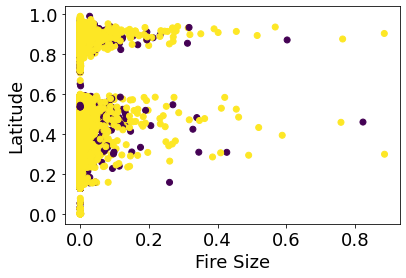

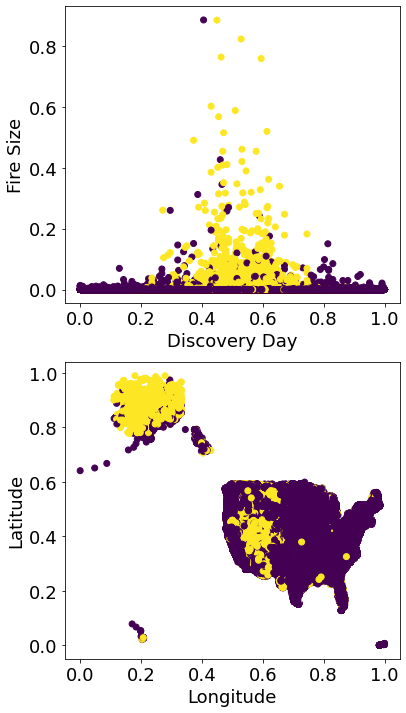

In [11]:
plt.scatter(rel_train['FIRE_SIZE'], rel_train['LATITUDE'], c=kmeans.labels_)
plt.xlabel('Fire Size')
plt.ylabel('Latitude')

fig, axes = plt.subplots(2,1, figsize=(6,12))
axes[0].scatter(rel_train['DISCOVERY_DOY'], rel_train['FIRE_SIZE'], c=rel_train['cause_lightning'])
axes[0].set_xlabel('Discovery Day')
axes[0].set_ylabel('Fire Size')
axes[1].scatter(rel_train['LONGITUDE'], rel_train['LATITUDE'], c=rel_train['cause_lightning'])
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')

Because we trained our clustering algorithm on location (latitude and longitude), the algorithm divided the data into two clusters, primarily clustering according to whether the fire was in Alaska or in the mainland US. The unsupervised learning was a good test that the data makes sense but is not very predictive as to whether the cause of a given fire was lightning.

# 3. Supervised machine learning

## 3. a) Binary Classification Test

As in the tutorial, we will use the method of logistic regression. For this method, we model the probability distribution for a binary classifier as 
\\[
p(y_i = 1 | \mathbf{x}_i, \mathbf{w}) \equiv \sigma(\mathbf{x}_i^T \mathbf{w}) = \frac{1}{1 + \exp(-\mathbf{x}_i^T \mathbf{w})} 
\\]

Here $\mathbf{x}_i$ is the __feature vector__ and $\mathbf{y}_i$ is the __label__ for the $i$-th data point.  The weights $\mathbf{w}$ define the model: a larger weight for a given component of $\mathbf{x}$ will give that feature more influence on the probability distribution.

The cost function is readily found as the log-likelihood of the whole dataset to be

\\[
C(\mathbf{w}) = -\log \prod_i P(y_i = 1)^{y_i} P(y_i = 0)^{1-y_i} \\
= -\sum_{i} \left[\mathbf{y}_i \log \sigma (\mathbf{x}_i^T \mathbf{w}) + (1-\mathbf{y}_i) \log (1 - \sigma(\mathbf{x}_i^T \mathbf{w}) ) \right].
\\]

In [12]:
def sigmoid(s):
    return 1 / (1 + np.exp(-s))

def cross_entropy(x, w, y):
    """
    Compute the cross entropy, a.k.a. the log likelihood
    for the logistic regression model..
    
    Inputs:
      - x: 2d array of feature vectors, with features as columns.
      - w: 1d array of feature weights, same length as a feature vector.
      - y: 1d array of data labels, should be binary (1 or 0)
      
    Return:
      - C(w): the cross entropy.
    """
    
    y = y.astype(int)
    xw = np.matmul(x,w)
    s = sigmoid(xw)
    Ci = np.multiply(y,np.log(s)) + np.multiply((1 - y),np.log(1-s))
    C = -sum(Ci)
    
        
    return C
    

In [13]:
import scipy.optimize as opt

features = ['FIRE_YEAR', 'DISCOVERY_DOY', 'FIRE_SIZE', 'LATITUDE','LONGITUDE']


def CE_train(w):
    return cross_entropy(rel_train[features].values, w, rel_train['cause_lightning'].values)

np.seterr(all = 'ignore') 
res = opt.minimize(CE_train, [0,0,0,0,0])
w_opt = res.x
np.seterr(all = 'warn') 

{'divide': 'ignore', 'over': 'ignore', 'under': 'ignore', 'invalid': 'ignore'}

In [14]:
rel_train['p_lightning'] = sigmoid(np.sum(rel_train[features].values * w_opt, axis=1))

/var/folders/b_/cqsdh0494d95ffr4z95wlkyr0000gn/T/ipykernel_8368/2765966117.py:2: RuntimeWarning: underflow encountered in exp
  return 1 / (1 + np.exp(-s))
/var/folders/b_/cqsdh0494d95ffr4z95wlkyr0000gn/T/ipykernel_8368/1458392268.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rel_train['p_lightning'] = sigmoid(np.sum(rel_train[features].values * w_opt, axis=1))


Text(0.5, 1.0, 'Train Data')

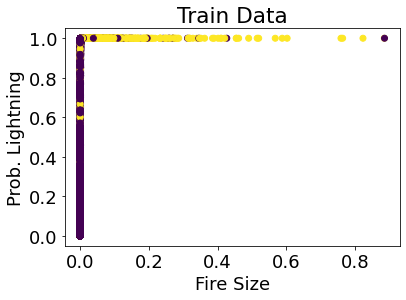

In [15]:
plt.scatter(rel_train['FIRE_SIZE'], rel_train['p_lightning'], c=rel_train['cause_lightning'])
plt.xlabel('Fire Size')
plt.ylabel('Prob. Lightning')
plt.title('Train Data')

Let's verify how well the algorithm does on the test data:

/var/folders/b_/cqsdh0494d95ffr4z95wlkyr0000gn/T/ipykernel_8368/2765966117.py:2: RuntimeWarning: underflow encountered in exp
  return 1 / (1 + np.exp(-s))
/var/folders/b_/cqsdh0494d95ffr4z95wlkyr0000gn/T/ipykernel_8368/3143443404.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rel_test['p_lightning'] = sigmoid(np.sum(rel_test[features].values * w_opt, axis=1))


Text(0.5, 1.0, 'Test Data')

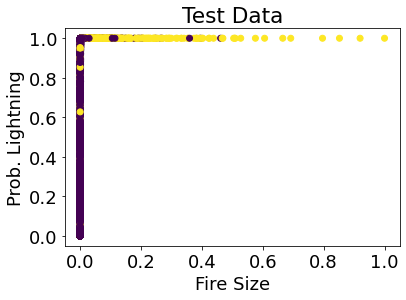

In [16]:
rel_test['p_lightning'] = sigmoid(np.sum(rel_test[features].values * w_opt, axis=1))

plt.scatter(rel_test['FIRE_SIZE'], rel_test['p_lightning'], c=rel_test['cause_lightning'])
plt.xlabel('Fire Size')
plt.ylabel('Prob. Lightning')
plt.title('Test Data')

Let's quantify exactly how well it's doing. We define the __false positive rate__ (number of non-lightning events incorrectly labelled as caused by lightning, divided by the total number of events) and the __false negative rate__ (lightning events labelled as non-lightning).  

We set the threshold for lightning events at $p > 0.5$.

In [17]:
false_positive = np.sum(~rel_test[rel_test['p_lightning'] > .5]['cause_lightning']) / len(rel_test) 
false_negative = np.sum(rel_test[rel_test['p_lightning'] < 0.5]['cause_lightning']) / len(rel_test) 

print("False positive rate: ", false_positive)
print("False negative rate: ", false_negative)

False positive rate:  0.25422321603296844
False negative rate:  0.06750670534470651


We see okay performance with regards to both false negatives and false positives. Let's try a full classification test so we can extend our model.

## 3. b) Full Classification Test

For the full classification of wildfire causes, we will move to a non-binary classification model. I'll try the Random Forest model.

### Features and Labels

Let's drop all rows where the cause is missing/undefined or miscellaneous and focus on causes the model would actually be able to predict so we don't throw off the model.

In [18]:
features_df = pd.read_sql('SELECT FIRE_YEAR, DISCOVERY_DOY,  STAT_CAUSE_CODE, STAT_CAUSE_DESCR, FIRE_SIZE, LATITUDE, LONGITUDE FROM fires',conn)
features = ['FIRE_YEAR', 'DISCOVERY_DOY', 'FIRE_SIZE', 'LATITUDE','LONGITUDE']
#features_df["DISCOVERY_TIME"] = pd.to_numeric(features_df['DISCOVERY_TIME'])

features_df.drop(features_df.index[features_df['STAT_CAUSE_DESCR'] == 'Missing/Undefined'], inplace=True)
features_df.drop(features_df.index[features_df['STAT_CAUSE_DESCR'] == 'Miscellaneous'], inplace=True)

for col_name in ['FIRE_YEAR', 'DISCOVERY_DOY', 'FIRE_SIZE', 'LATITUDE','LONGITUDE']:
    features_df[col_name] = normalize_col(features_df[col_name])
    
features_df 
features_df_test = features_df.copy()



In [19]:
# Use numpy to convert to arrays

# Labels are the values we want to predict
labels = np.array(features_df['STAT_CAUSE_CODE'])
labels_descr = np.array(features_df['STAT_CAUSE_DESCR'])

# Remove the labels from the features
features_df = features_df.drop(['STAT_CAUSE_DESCR','STAT_CAUSE_CODE'], axis = 1)

# Saving feature names for later use
feature_list = list(features_df.columns)

# Convert to numpy array
features_pd_df = features_df
features_df = np.array(features_df)

### Training and test datasets

In [20]:
# Skicit-learn splits data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features_df, labels, test_size = 0.4, random_state = 42)

In [21]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (833962, 5)
Training Labels Shape: (833962,)
Testing Features Shape: (555975, 5)
Testing Labels Shape: (555975,)


### Training the forest

We train the forest with a random forest classifier model. We start with a low number of estimators (n_estimators = 10) so that it does not take too long since the dataset is so large. We set the seed with random_state = 42 so that the training is deterministic. 

In [22]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

# Instantiate model 
rf = RandomForestClassifier(n_estimators= 10,random_state = 42)

# Train the model on training data
rf.fit(train_features, train_labels);

### Testing the predictions

In [23]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)

# metrics are used to find accuracy or error
from sklearn import metrics 
print()
 
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL ON TEST SET: ", metrics.accuracy_score(test_labels, predictions))


ACCURACY OF THE MODEL ON TEST SET:  0.5910967219749089


In [24]:
print(test_labels[0:10])
print(predictions[0:10])


[5. 7. 7. 4. 8. 4. 2. 2. 5. 1.]
[5. 5. 7. 5. 1. 1. 5. 2. 5. 1.]


59% accuracy doesn't seem very good, but considering that some of the wildfire causes would look pretty similar from the data available (for example distinguishing between wildfires started by children vs. by arson), the model does not seem too bad. How accurate is the model on the training data? That could be an indicator of whether there is too much variability in the data to do much better with our model.

In [25]:
# Use the forest's predict method on the test data
predictionsTrain = rf.predict(train_features)
 
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL ON TRAIN SET: ", metrics.accuracy_score(train_labels, predictionsTrain))

ACCURACY OF THE MODEL ON TRAIN SET:  0.9836587278557056


The model is performing extremely well on the training data set and much worse on the testing data set. This suggests the model is overfitting quite a bit. 

### Tuning the hyperparameters to optimize the model

Note: I tried using GridSearchCV for a comprehensive and through search through the hyperparameter space but it was too computationally expensive on the large dataset. Instead, I will try using a randomized search to reduce computational time.

First, we look at our current hyperparameter values.

In [26]:
from pprint import pprint
# Look at parameters used by our current forest
print('Currently using parameters:\n')
pprint(rf.get_params())

Currently using parameters:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


Some parameters that could be optimized are number of trees in the forest (n_estimators), number of levels in the tree (max_depth), minimum number of samples to split a node, etc.

In [27]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in forest
n_estimators = [int(x) for x in np.linspace(100,1000,10)]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, 10)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)
{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}


{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}

Now that we have a long list of hyperparameter combinations to try, we use a random grid to search for the best combination. We will start with trying just 20 different combinations and using 2 cores so the process does not take prohibitively long. Tried using all available cores but it kept shutting my computer down for some reason.

In [28]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation, 
# search across 20 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, random_state=42, n_jobs = 2)

# Fit the random search model
rf_random.fit(train_features, train_labels)



Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=4, min_samples_split=5, n_estimators=900; total time=28.8min
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=4, min_samples_split=5, n_estimators=900; total time=28.5min
[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time= 4.4min
[CV] END bootstrap=False, max_depth=80, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time= 6.1min
[CV] END bootstrap=False, max_depth=80, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time= 6.1min
[CV] END bootstrap=False, max_depth=90, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time= 3.1min
[CV] END bootstrap=False, max_depth=90, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=12.2min
[CV] END bootstrap=False, max_depth=90, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=20,
                   n_jobs=2,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=42, verbose=2)

In [29]:
rf_random.best_params_

{'n_estimators': 500,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_depth': 60,
 'bootstrap': True}

In [30]:
def evaluate_model(model, test_features, test_labels):
    predictions = model.predict(test_features)
    accuracy = metrics.accuracy_score(test_labels, predictions)
    print('Model Performance')
    print('Accuracy = {:0.2f}%.'.format(100*accuracy))
    
    return accuracy
base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
base_model.fit(train_features, train_labels)
base_accuracy = evaluate_model(base_model, test_features, test_labels)

Model Performance
Accuracy = 59.11%.


In [31]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate_model(best_random, test_features, test_labels)

Model Performance
Accuracy = 62.37%.


In [32]:
def model_improvement(new_accuracy, base_accuracy):
    return 100 * (new_accuracy - base_accuracy) / base_accuracy

In [33]:
print('Improvement of {:0.2f}%.'.format(model_improvement(random_accuracy,base_accuracy)))

Improvement of 5.52%.


We improved our model accuracy by around 5% using a random grid search! To do this more thoroughly, I would implement more iterations of the random grid search ie. n_iter = 100 or I would perform a GridSearchCV for a thorough and comprehensive search through the hyper-parameter space. This would be massively computationally expensive though, given the size of the dataset. 

### Identifying and visualizing important features

In [42]:
feature_imp = pd.Series(best_random.feature_importances_,index=features).sort_values(ascending=False)
feature_imp

LONGITUDE        0.342247
LATITUDE         0.254900
DISCOVERY_DOY    0.207914
FIRE_YEAR        0.103246
FIRE_SIZE        0.091693
dtype: float64

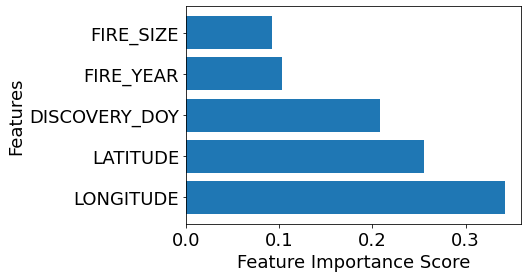

In [43]:
# Creating a bar plot
plt.barh(feature_imp.index, feature_imp)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.show()

If we remove the least important features in the model: fire size and fire year, can we improve the accuracy of the model? 

### Removing less important features from the best random model

In [36]:
# Remove fire size and fire year from the features
features_min_df = features_pd_df.drop(['FIRE_SIZE','FIRE_YEAR'], axis = 1)

# Saving feature names for later use
feature_list_min = list(features_min_df.columns)

# Convert to numpy array
features_min_df = np.array(features_min_df)

In [37]:
# Split the data into training and testing sets
train_features_min, test_features_min, train_labels_min, test_labels_min = train_test_split(features_min_df, labels, test_size = 0.4, random_state = 42)


In [38]:
# Instantiate model 
rf_min = RandomForestClassifier(n_estimators= 500, min_samples_split = 5, min_samples_leaf = 1, max_depth = 60, bootstrap = True, random_state = 42)

# Train the model on training data
rf_min.fit(train_features_min, train_labels_min);


In [39]:
# Use the forest's predict method on the test data
predictions_min = rf_min.predict(test_features_min)
 
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(test_labels_min, predictions_min))

ACCURACY OF THE MODEL:  0.5875839740995549


The model has gotten worse so we can conclude that the fire size and fire year features are important. 

### Outlook

In conclusion, I have developed a model that evaluates location, fire size, and the date to classify fires according to their cause. The model I have developed is ~83% accurate, which I am satisfied with considering the variability in the dataset. Next steps for the project would be to perform a more thorough and comprehensive tuning of the hyperparameters, maybe via a GridSearch instead of a RandomSearch through the hyper-parameter space. With this work, I have made significant progress towards the stated goal of being able to classify wildfires based on their cause. This work could be taken as a step towards the more challenging goal of assessing wildfire risk.

# Unit Testing Suite

Note: I tried to make a unit testing suite in a separate notebook/python file to the main code base. Unfortunately, I couldn't figure out a way to unit test the main code base without re-running the entire file which would re-run the hyperparameter tuning section and take many hours. Instead, I have decided to include the unit testing suite at the bottom of the main code-base to save some time. I understand the advantage of having a separate testing suite, however, and in a more official project setting, I would do that instead.

In [40]:
import unittest

In [45]:
class TestNotebook(unittest.TestCase):
        
    def test_normalize_col(self):
        x_test = np.linspace(0,5,6)
        self.assertEqual(normalize_col(x_test).all(),np.linspace(0,1,6).all())
        
    def test_colMins(self):
        for col_name in ['FIRE_YEAR', 'DISCOVERY_DOY', 'FIRE_SIZE', 'LATITUDE','LONGITUDE']:
            self.assertEqual(rel_df[col_name].min(),0)
            self.assertEqual(rel_df[col_name].max(),1)
        
    
    def test_dataSplit(self):
        ratioToTest = 0.2
        rel_train, rel_test = data_split(rel_df,ratioToTest)
        dataRatio = rel_test.shape[0]/(rel_test.shape[0] + rel_train.shape[0])
        self.assertAlmostEqual(dataRatio, ratioToTest,2)
        
    def test_dataSplitRatioEdge(self):
        ratioToTest = 0
        rel_train, rel_test = data_split(rel_df,ratioToTest)
        dataRatio = rel_test.shape[0]/(rel_test.shape[0] + rel_train.shape[0])
        self.assertAlmostEqual(dataRatio, ratioToTest,2)
        
    def test_cross_entropy(self):
        x_test = np.array([[0,1],[1,1]])
        y_test = np.array([0,1])
        w_test = np.array([0.2,0.4])
        self.assertAlmostEqual(cross_entropy(x_test, w_test, y_test), 1.35,2)
        
    def test_sigmoid(self):
        sToTest = 0
        outputOfFunc = sigmoid(sToTest)
        self.assertEqual(outputOfFunc,0.5)
        
    def test_binary_probs(self):
        false_pos = np.sum(~rel_test[rel_test['p_lightning'] > .5]['cause_lightning']) / len(rel_test) 
        false_neg = np.sum(rel_test[rel_test['p_lightning'] < 0.5]['cause_lightning']) / len(rel_test)  
        true_pos = np.sum(rel_test[rel_test['p_lightning'] > .5]['cause_lightning']) / len(rel_test)
        true_neg = np.sum(~rel_test[rel_test['p_lightning'] < 0.5]['cause_lightning']) / len(rel_test) 
        sumProbs = false_pos + false_neg + true_pos + true_neg
        self.assertAlmostEqual(sumProbs,1,5)
        
    def test_featuresDF(self):
        for col_name in ['FIRE_YEAR', 'DISCOVERY_DOY', 'FIRE_SIZE', 'LATITUDE','LONGITUDE']:
            self.assertEqual(features_df_test[col_name].min(),0)
            self.assertEqual(features_df_test[col_name].max(),1)
            
    def test_featureImp(self):
        self.assertAlmostEqual(sum(feature_imp),1,3)
        
    def test_randomStatePreds(self):
        rf1 = RandomForestClassifier(n_estimators = 1,random_state = 42)
        rf1.fit(train_features, train_labels);
        predictions1 = rf1.predict(test_features)
        rf2 = RandomForestClassifier(n_estimators = 1, random_state = 42)
        rf2.fit(train_features,train_labels);
        predictions2 = rf2.predict(test_features)
        self.assertEqual(predictions1.all(),predictions2.all())
        
    def test_metricAccuracy(self):
        sample_labels = np.ones((1,10))
        sample_labels_zero = np.zeros((1,10))
        test_Acc = metrics.accuracy_score(sample_labels, sample_labels)
        test_notAcc = metrics.accuracy_score(sample_labels,sample_labels_zero)
        self.assertEqual(test_Acc,1.0)
        self.assertEqual(test_notAcc,0.0)
        
    def test_model_improvement(self):
        self.assertEqual(model_improvement(0.7,0.7),0.0)
        self.assertEqual(model_improvement(1.0,0.5),100.0)

        

unittest.main(argv=[''], verbosity=2, exit=False)

test_binary_probs (__main__.TestNotebook) ... ok
test_colMins (__main__.TestNotebook) ... ok
test_cross_entropy (__main__.TestNotebook) ... ok
test_dataSplit (__main__.TestNotebook) ... ok
test_dataSplitRatioEdge (__main__.TestNotebook) ... ok
test_featureImp (__main__.TestNotebook) ... ok
test_featuresDF (__main__.TestNotebook) ... ok
test_metricAccuracy (__main__.TestNotebook) ... ok
test_model_improvement (__main__.TestNotebook) ... ok
test_normalize_col (__main__.TestNotebook) ... ok
test_randomStatePreds (__main__.TestNotebook) ... ok
test_sigmoid (__main__.TestNotebook) ... ok

----------------------------------------------------------------------
Ran 12 tests in 6.580s

OK
